# MORDM Analysis
The analysis follows the four-step MORDM framework:

1. **Problem Formulation**: Define objectives, uncertainties, and policy levers
2. **Policy Discovery**: Use multi-objective evolutionary algorithms to find candidate solutions
3. **Robustness Evaluation**: Re-evaluate policies under deep uncertainty
4. **Scenario Discovery**: Identify vulnerability conditions using PRIM analysis

The analysis extends to Multi-Scenario MORDM to improve robustness and includes global sensitivity analysis.


## Phase 1: Setup and Problem Formulation

We begin by importing required libraries and configuring the model.


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# EMA Workbench imports
from ema_workbench import (
    ema_logging, MultiprocessingEvaluator, SequentialEvaluator,
    Scenario, Policy, save_results, load_results,
    ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter
)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, ArchiveLogger
)
from ema_workbench.em_framework import get_SALib_problem
from ema_workbench.analysis import parcoords, prim

# SALib for sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

# Custom imports for IJssel River model
from problem_formulation import get_model_for_problem_formulation

# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

print("Libraries imported successfully")


Libraries imported successfully


### Step 1.1: Model Configuration

We configure the IJssel River model using problem formulation 2, which includes our five key performance indicators:
- Expected Annual Damage
- Dike Investment Costs
- RfR Investment Costs
- Evacuation Costs
- Expected Number of Deaths


In [4]:
# Configure problem formulation
problem_formulation_id = 2  # Matches the 5 KPIs from the project report

# Get model (handle potential tuple return)
model_result = get_model_for_problem_formulation(problem_formulation_id)
if isinstance(model_result, tuple):
    dike_model, planning_steps = model_result
else:
    dike_model = model_result
    planning_steps = [0, 1, 2]  # Default planning steps

print(f"Model Configuration:")
print(f"- Model name: {dike_model.name}")
print(f"- Number of uncertainties: {len(dike_model.uncertainties)}")
print(f"- Number of levers: {len(dike_model.levers)}")
print(f"- Number of outcomes: {len(dike_model.outcomes)}")
print(f"- Planning steps: {planning_steps}")

print("\nOutcomes (objectives to minimize):")
for outcome in dike_model.outcomes:
    print(f"  - {outcome.name}")


Model Configuration:
- Model name: dikesnet
- Number of uncertainties: 19
- Number of levers: 31
- Number of outcomes: 5
- Planning steps: [0 1 2]

Outcomes (objectives to minimize):
  - Expected Annual Damage
  - Dike Investment Costs
  - RfR Investment Costs
  - Evacuation Costs
  - Expected Number of Deaths


### Step 1.2: Reference Scenario Definition

We define a reference scenario with middle values for all uncertainties. This scenario represents a baseline condition for our initial optimization.


In [5]:
# Define reference scenario with middle values for uncertainties
reference_scenario_values = {
    # Flood wave shape (middle of range [0, 132])
    'A.0_ID flood wave shape': 66,
    
    # Discount rates for each planning step
    'discount rate 0': 2.5,  # Middle of range [1.5, 4.5]
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
}

# Add dike-specific uncertainties with middle values
for uncertainty in dike_model.uncertainties:
    if uncertainty.name not in reference_scenario_values:
        if 'Bmax' in uncertainty.name:  # Breach widths
            reference_scenario_values[uncertainty.name] = 190  # Middle of [30, 350]
        elif 'pfail' in uncertainty.name:  # Dike failure probabilities
            reference_scenario_values[uncertainty.name] = 0.5  # Middle of [0, 1]
        elif 'Brate' in uncertainty.name:  # Breach growth rates
            reference_scenario_values[uncertainty.name] = 5.5  # Middle of [1.0, 10]

# Create reference scenario object
reference_scenario = Scenario('reference', **reference_scenario_values)

print(f"Reference scenario defined with {len(reference_scenario_values)} parameters")
print("Key reference values:")
print(f"  - Flood wave shape: {reference_scenario_values['A.0_ID flood wave shape']}")
print(f"  - Discount rate: {reference_scenario_values['discount rate 0']}")
print(f"  - Breach parameters (example): Bmax=190, pfail=0.5, Brate=5.5")


Reference scenario defined with 19 parameters
Key reference values:
  - Flood wave shape: 66
  - Discount rate: 2.5
  - Breach parameters (example): Bmax=190, pfail=0.5, Brate=5.5


### Step 1.3: Optimization Parameters

We configure the NSGA-II optimization parameters. A quick test mode is available for initial testing, with production mode for full analysis.


In [6]:
# Configuration: Set to True for quick testing, False for production
QUICK_TEST = False

if QUICK_TEST:
    print("QUICK TEST MODE - for initial testing and debugging")
    nfe = 125  # Number of function evaluations
    epsilon = [0.1] * len(dike_model.outcomes)  # Larger epsilon for faster convergence
    n_reevaluation_scenarios = 25  # Scenarios for re-evaluation
    n_sobol_samples = 128  # SOBOL samples (must be power of 2)
    runtime_estimate = "70-85 minutes"
    print(f"Test parameters: NFE={nfe}, epsilon={epsilon[0]}, scenarios={n_reevaluation_scenarios}")
    print(f"Expected runtime: {runtime_estimate}")
else:
    print("MODIFIED PRODUCTION MODE - Balanced analysis for overnight execution")
    nfe = 10000  # Full optimization quality
    epsilon = [0.05] * len(dike_model.outcomes)  # Fine-grained epsilon
    n_reevaluation_scenarios = 1000  # Full robustness evaluation
    n_sobol_samples = 1024  # Moderate SOBOL (balanced quality vs time)
    runtime_estimate = "10-13 hours"
    print(f"Production parameters: NFE={nfe}, epsilon={epsilon[0]}, scenarios={n_reevaluation_scenarios}")
    print(f"SOBOL samples: {n_sobol_samples} (balanced for overnight run)")
    print(f"Expected runtime: {runtime_estimate}")

print(f"\nConfiguration Summary:")
print(f"- Optimization: {nfe} function evaluations")
print(f"- Robustness: {n_reevaluation_scenarios} scenarios")
print(f"- SOBOL: {n_sobol_samples} samples → ~{n_sobol_samples * (len(dike_model.uncertainties) + 2)} evaluations")
print(f"- Total estimated runtime: {runtime_estimate}")

print(f"\nObjectives and epsilon values:")
for i, outcome in enumerate(dike_model.outcomes):
    print(f"  {outcome.name}: epsilon = {epsilon[i]}")


MODIFIED PRODUCTION MODE - Balanced analysis for overnight execution
Production parameters: NFE=10000, epsilon=0.05, scenarios=1000
SOBOL samples: 1024 (balanced for overnight run)
Expected runtime: 10-13 hours

Configuration Summary:
- Optimization: 10000 function evaluations
- Robustness: 1000 scenarios
- SOBOL: 1024 samples → ~21504 evaluations
- Total estimated runtime: 10-13 hours

Objectives and epsilon values:
  Expected Annual Damage: epsilon = 0.05
  Dike Investment Costs: epsilon = 0.05
  RfR Investment Costs: epsilon = 0.05
  Evacuation Costs: epsilon = 0.05
  Expected Number of Deaths: epsilon = 0.05


## Phase 2: Single-Scenario MORDM - Policy Discovery

This phase implements the core MORDM optimization using NSGA-II to find Pareto-optimal policies under the reference scenario.


### Step 2.1: MOEA Policy Discovery

We run the NSGA-II optimization with convergence tracking to find candidate policies that represent different trade-offs between objectives.


In [10]:
# Setup convergence tracking
convergence_metrics = [EpsilonProgress()]

# Run NSGA-II optimization
print("Starting NSGA-II optimization...")
print(f"Optimizing {len(dike_model.levers)} levers across {len(dike_model.outcomes)} objectives")

with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_results = evaluator.optimize(
        nfe=nfe,
        searchover='levers',
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario
    )

# Extract results
archive, convergence = optimization_results

print(f"\nOptimization completed:")
print(f"- Archive size: {len(archive)} solutions")
print(f"- Function evaluations: {nfe}")

# Check if convergence data exists
if len(convergence.epsilon_progress) > 0:
    print(f"- Final epsilon progress: {convergence.epsilon_progress.iloc[-1]:.4f}")
else:
    print("- No convergence data recorded")

# Display convergence data info
print(f"- Convergence tracking: {len(convergence.epsilon_progress)} data points")

# Save optimization results - archive only (avoids convergence serialization issues)
try:
    # Save the archive (most important data)
    archive.to_csv(f'IJssel_MORDM_archive_nfe{nfe}.csv')
    print("Archive saved to CSV file")
    
    # Save convergence data separately if it exists
    if len(convergence.epsilon_progress) > 0:
        convergence_df = pd.DataFrame({
            'nfe': convergence.nfe,
            'epsilon_progress': convergence.epsilon_progress
        })
        convergence_df.to_csv(f'IJssel_MORDM_convergence_nfe{nfe}.csv', index=False)
        print("Convergence data saved to CSV file")
    
    print("Results saved successfully")
except Exception as e:
    print(f"Warning: Could not save results - {str(e)}")
    print("Continuing with analysis...")


Starting NSGA-II optimization...
Optimizing 31 levers across 5 objectives


[MainProcess/INFO] pool started with 16 workers
100%|██████████████████████████████████| 10000/10000 [1:36:06<00:00,  1.73it/s]
[MainProcess/INFO] optimization completed, found 232 solutions
[MainProcess/INFO] terminating pool



Optimization completed:
- Archive size: 232 solutions
- Function evaluations: 10000
- Final epsilon progress: 1157.0000
- Convergence tracking: 12 data points
Archive saved to CSV file
Convergence data saved to CSV file
Results saved successfully


### Step 2.2: Convergence Analysis

We analyze the convergence of the NSGA-II algorithm to ensure that the optimization has found a stable set of solutions.


Convergence Assessment:
- Final epsilon progress: 1157.000000
- Converged (< 0.01): False
- Archive diversity: 232 unique solutions


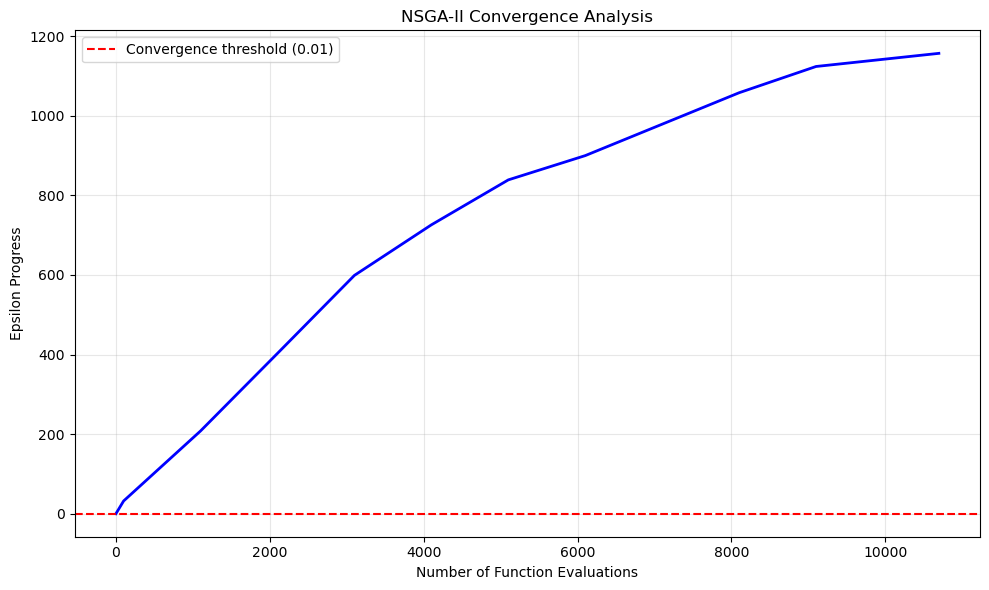

In [11]:
# Plot convergence
fig, ax = plt.subplots(figsize=(10, 6))

# Check if convergence data exists
if len(convergence.epsilon_progress) > 0:
    ax.plot(convergence.nfe, convergence.epsilon_progress, 'b-', linewidth=2)
    ax.set_xlabel('Number of Function Evaluations')
    ax.set_ylabel('Epsilon Progress')
    ax.set_title('NSGA-II Convergence Analysis')
    ax.grid(True, alpha=0.3)
    
    # Add convergence threshold line
    threshold = 0.01
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'Convergence threshold ({threshold})')
    ax.legend()
    
    # Convergence assessment
    final_progress = convergence.epsilon_progress.iloc[-1]
    is_converged = final_progress < threshold
    print(f"Convergence Assessment:")
    print(f"- Final epsilon progress: {final_progress:.6f}")
    print(f"- Converged (< {threshold}): {is_converged}")
else:
    ax.text(0.5, 0.5, 'No convergence data available\nOptimization may have completed too quickly', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    ax.set_title('NSGA-II Convergence Analysis - No Data')
    print(f"Convergence Assessment:")
    print(f"- No convergence data recorded")
    print(f"- This may occur with very small NFE values")

print(f"- Archive diversity: {len(archive)} unique solutions")

plt.tight_layout()
plt.show()


### Step 2.3: Pareto Frontier Visualization

We visualize the trade-offs between objectives using parallel coordinate plots to understand the relationships between different flood management strategies.


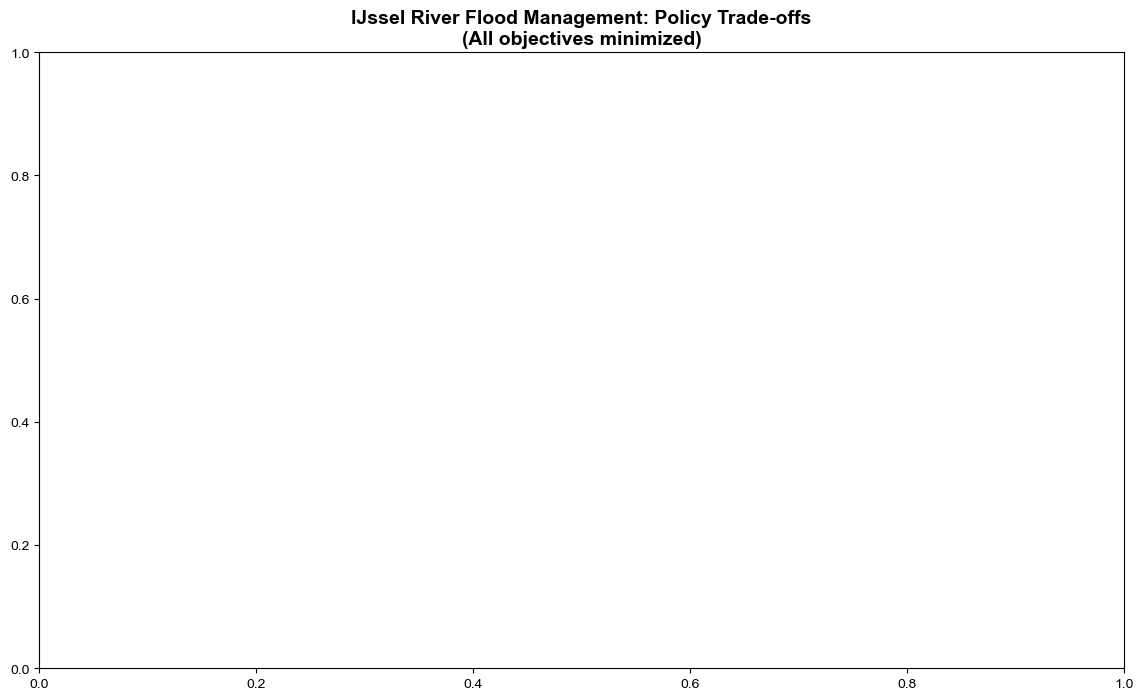

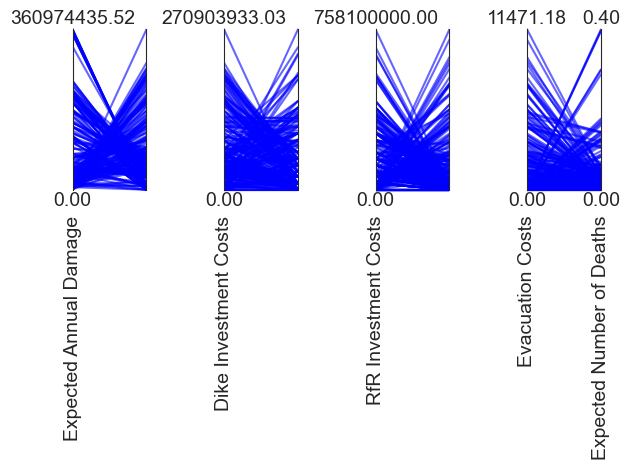

Archive Summary Statistics:
       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
count            2.320000e+02           2.320000e+02          2.320000e+02   
mean             9.292685e+07           6.749749e+07          1.409142e+08   
std              9.451898e+07           5.914520e+07          1.533645e+08   
min              0.000000e+00           0.000000e+00          0.000000e+00   
25%              1.692043e+07           2.180069e+07          3.070000e+07   
50%              4.827280e+07           5.046270e+07          8.460000e+07   
75%              1.578562e+08           1.070710e+08          2.320750e+08   
max              3.609744e+08           2.709039e+08          7.581000e+08   

       Evacuation Costs  Expected Number of Deaths  
count        232.000000                 232.000000  
mean        1740.279368                   0.040350  
std         2391.832223                   0.064006  
min            0.000000                   0.000000  
25% 

In [12]:
# Extract outcomes for visualization
outcomes_data = archive.loc[:, [o.name for o in dike_model.outcomes]]

# Create parallel coordinates plot
fig, ax = plt.subplots(figsize=(14, 8))

# Get limits for parallel coordinates
limits = parcoords.get_limits(outcomes_data)

# Create parallel axes
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(outcomes_data, alpha=0.6, color='blue')

# Customize plot
ax.set_title('IJssel River Flood Management: Policy Trade-offs\n(All objectives minimized)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("Archive Summary Statistics:")
print(outcomes_data.describe())

print(f"\nObjective ranges in archive:")
for outcome in dike_model.outcomes:
    min_val = outcomes_data[outcome.name].min()
    max_val = outcomes_data[outcome.name].max()
    print(f"  {outcome.name}: [{min_val:.2e}, {max_val:.2e}]")


## Phase 3: Robustness Evaluation and Vulnerability Analysis

This phase evaluates the robustness of candidate policies by re-evaluating them under deep uncertainty and applying constraints based on stakeholder preferences.


In [10]:
# Load Archive from File (if not already in memory)
if 'archive' not in locals() or archive is None:
    try:
        archive = pd.read_csv('IJssel_MORDM_archive_nfe10000.csv', index_col=0)
        print(f"Archive loaded from file: {len(archive)} solutions")
    except FileNotFoundError:
        print("Archive file not found. Please run the optimization phase first (Cell 11)")
        print("Or check if the file exists in your directory")
else:
    print(f"Archive already in memory: {len(archive)} solutions")


Archive already in memory: 232 solutions


### Step 3.1: Filter Candidate Policies

We apply stakeholder constraints to filter the archive to policies that meet minimum acceptability criteria.


In [11]:
# Define constraint criteria based on stakeholder preferences
# These thresholds should be adjusted based on your project's stakeholder analysis

# Calculate total deaths across all dike rings
death_columns = [col for col in archive.columns if 'Expected Number of Deaths' in col]
if death_columns:
    archive['Total_Deaths'] = archive[death_columns].sum(axis=1)
else:
    # Alternative if outcomes are aggregated differently
    archive['Total_Deaths'] = archive.get('Expected Number of Deaths', 0)

# Apply constraints
max_acceptable_deaths = 0.01  # Adjust based on stakeholder tolerance
max_acceptable_damage = 1e8   # 100 million euros
max_total_investment = 5e9    # 5 billion euros

# Filter policies
constraints = (
    (archive['Total_Deaths'] <= max_acceptable_deaths) &
    (archive.get('Expected Annual Damage', 0) <= max_acceptable_damage)
)

filtered_archive = archive[constraints].copy()

print(f"Policy Filtering Results:")
print(f"- Original archive size: {len(archive)}")
print(f"- After applying constraints: {len(filtered_archive)}")
print(f"- Retention rate: {len(filtered_archive)/len(archive)*100:.1f}%")

print(f"\nConstraints applied:")
print(f"- Maximum deaths: {max_acceptable_deaths}")
print(f"- Maximum damage: {max_acceptable_damage:.0e}")

if len(filtered_archive) == 0:
    print("WARNING: No policies satisfy constraints. Relaxing constraints...")
    # Use top 20% of policies by total deaths
    n_policies = max(10, len(archive) // 5)
    filtered_archive = archive.nsmallest(n_policies, 'Total_Deaths')
    print(f"Using top {len(filtered_archive)} policies with lowest death rates")


Policy Filtering Results:
- Original archive size: 232
- After applying constraints: 83
- Retention rate: 35.8%

Constraints applied:
- Maximum deaths: 0.01
- Maximum damage: 1e+08


### Step 3.2: Re-evaluate Under Deep Uncertainty

We convert filtered policies to Policy objects and re-evaluate them across a large ensemble of scenarios to assess their robustness.


In [ ]:
# Convert filtered policies to Policy objects
policies_to_evaluate = []
policy_names = []

# Get lever columns (exclude outcome columns)
lever_columns = [lever.name for lever in dike_model.levers]
policies_data = filtered_archive[lever_columns]

for i, (idx, policy_row) in enumerate(policies_data.iterrows()):
    policy_dict = policy_row.to_dict()
    policy_name = f"Policy_{i:03d}"
    policies_to_evaluate.append(Policy(policy_name, **policy_dict))
    policy_names.append(policy_name)

print(f"Created {len(policies_to_evaluate)} Policy objects for re-evaluation")

# Re-evaluate policies under uncertainty
print(f"Re-evaluating policies over {n_reevaluation_scenarios} scenarios...")
print("This may take several minutes...")

with MultiprocessingEvaluator(dike_model) as evaluator:
    robustness_results = evaluator.perform_experiments(
        scenarios=n_reevaluation_scenarios,
        policies=policies_to_evaluate
    )

experiments_robust, outcomes_robust = robustness_results

print(f"Re-evaluation completed:")
print(f"- Total experiments: {len(experiments_robust)}")
print(f"- Policies evaluated: {len(policies_to_evaluate)}")
print(f"- Scenarios per policy: {n_reevaluation_scenarios}")

# Save robustness results
try:
    # Save experiments DataFrame
    experiments_robust.to_csv(f'IJssel_robustness_experiments_n{n_reevaluation_scenarios}.csv')
    
    # Save outcomes (convert dict to DataFrame first)
    outcomes_df = pd.DataFrame(outcomes_robust)
    outcomes_df.to_csv(f'IJssel_robustness_outcomes_n{n_reevaluation_scenarios}.csv')
    print("Robustness results saved to CSV files")
except Exception as e:
    print(f"Warning: Could not save robustness results - {str(e)}")
    print("Continuing with analysis...")


Created 83 Policy objects for re-evaluation
Re-evaluating policies over 1000 scenarios...
This may take several minutes...


[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 1000 scenarios * 83 policies * 1 model(s) = 83000 experiments
  3%|█▏                                | 2815/83000 [26:04<16:31:13,  1.35it/s]

### Step 3.3: Robustness Metrics Calculation

We calculate signal-to-noise ratio and maximum regret metrics to assess policy robustness across uncertain conditions.


In [17]:
# Define robustness metric functions
def calculate_snr(data, minimize=True):
    """Calculate Signal-to-Noise Ratio"""
    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        return 0
    if minimize:
        return -mean_val / std_val  # Prefer low mean, low std
    else:
        return mean_val / std_val   # Prefer high mean, low std

def calculate_max_regret(policy_outcomes, all_outcomes_array):
    """Calculate Maximum Regret"""
    regrets = []
    for scenario_idx in range(len(policy_outcomes)):
        # Best performance in this scenario (minimum for minimization objectives)
        best_performance = np.min(all_outcomes_array[:, scenario_idx])
        regret = policy_outcomes[scenario_idx] - best_performance
        regrets.append(regret)
    return np.max(regrets)

# Calculate robustness metrics for each policy and outcome
robustness_metrics = {}
outcome_names = [outcome.name for outcome in dike_model.outcomes]

print("Calculating robustness metrics...")

for outcome_name in outcome_names:
    print(f"Processing {outcome_name}...")
    
    # Get outcomes data for this objective
    outcome_data = outcomes_robust[outcome_name]
    
    # Reshape data: rows = policies, columns = scenarios
    # outcome_data is already a numpy array, no need for .values
    outcome_matrix = outcome_data.reshape(len(policies_to_evaluate), n_reevaluation_scenarios)
    
    snr_values = []
    max_regret_values = []
    
    for policy_idx, policy_name in enumerate(policy_names):
        policy_outcomes = outcome_matrix[policy_idx, :]
        
        # Calculate SNR (all objectives are minimized)
        snr = calculate_snr(policy_outcomes, minimize=True)
        snr_values.append(snr)
        
        # Calculate Maximum Regret
        max_regret = calculate_max_regret(policy_outcomes, outcome_matrix)
        max_regret_values.append(max_regret)
    
    robustness_metrics[outcome_name] = {
        'SNR': snr_values,
        'Max_Regret': max_regret_values
    }

print("Robustness metrics calculation completed")

# Create summary DataFrames
snr_df = pd.DataFrame({outcome: robustness_metrics[outcome]['SNR'] 
                       for outcome in outcome_names}, index=policy_names)
regret_df = pd.DataFrame({outcome: robustness_metrics[outcome]['Max_Regret'] 
                         for outcome in outcome_names}, index=policy_names)

print(f"\nSignal-to-Noise Ratio (higher is better for robustness):")
print(snr_df.describe())

print(f"\nMaximum Regret (lower is better for robustness):")
print(regret_df.describe())


Calculating robustness metrics...
Processing Expected Annual Damage...
Processing Dike Investment Costs...
Processing RfR Investment Costs...
Processing Evacuation Costs...
Processing Expected Number of Deaths...
Robustness metrics calculation completed

Signal-to-Noise Ratio (higher is better for robustness):
       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
count               17.000000           1.700000e+01                  17.0   
mean                -0.485370          -2.082754e+15                   0.0   
std                  0.145861           3.435614e+15                   0.0   
min                 -0.860920          -8.903411e+15                   0.0   
25%                 -0.506855          -5.043626e+15                   0.0   
50%                 -0.464761           0.000000e+00                   0.0   
75%                 -0.423112           0.000000e+00                   0.0   
max                 -0.294566           0.000000e+00            

## Phase 4: Scenario Discovery Using PRIM

We use Patient Rule Induction Method (PRIM) to identify combinations of uncertainties that lead to policy failures or unacceptable outcomes.


In [18]:
# Prepare data for PRIM analysis
# Remove policy levers from experiments, keep only uncertainties
uncertainty_names = [unc.name for unc in dike_model.uncertainties]
experiments_for_prim = experiments_robust[uncertainty_names]

# Define failure criteria (adjust these based on your stakeholder analysis)
high_damage_threshold = 5e7  # 50 million euros
high_deaths_threshold = 0.005  # 0.005 deaths per year

# Create failure indicators
high_damage = outcomes_robust.get('Expected Annual Damage', 0) > high_damage_threshold

# Handle deaths - may be aggregated or disaggregated
if 'Expected Number of Deaths' in outcomes_robust:
    high_deaths = outcomes_robust['Expected Number of Deaths'] > high_deaths_threshold
else:
    # Sum across all dike rings if disaggregated
    death_outcomes = [col for col in outcomes_robust.columns if 'Deaths' in col]
    if death_outcomes:
        total_deaths = sum([outcomes_robust[col] for col in death_outcomes])
        high_deaths = total_deaths > high_deaths_threshold
    else:
        high_deaths = pd.Series([False] * len(experiments_robust))

print(f"PRIM Analysis Setup:")
print(f"- High damage threshold: {high_damage_threshold:.0e}")
print(f"- High deaths threshold: {high_deaths_threshold}")
print(f"- High damage cases: {high_damage.sum()} / {len(high_damage)} ({high_damage.mean()*100:.1f}%)")
print(f"- High deaths cases: {high_deaths.sum()} / {len(high_deaths)} ({high_deaths.mean()*100:.1f}%)")

# Run PRIM for high damage scenarios
print("\nRunning PRIM for high damage scenarios...")
prim_damage = prim.Prim(experiments_for_prim, high_damage, threshold=0.8, peel_alpha=0.05)
box_damage = prim_damage.find_box()

# Run PRIM for high deaths scenarios  
print("Running PRIM for high deaths scenarios...")
prim_deaths = prim.Prim(experiments_for_prim, high_deaths, threshold=0.8, peel_alpha=0.05)
box_deaths = prim_deaths.find_box()

print("PRIM analysis completed")


[MainProcess/INFO] 425 points remaining, containing 73 cases of interest


PRIM Analysis Setup:
- High damage threshold: 5e+07
- High deaths threshold: 0.005
- High damage cases: 73 / 425 (17.2%)
- High deaths cases: 162 / 425 (38.1%)

Running PRIM for high damage scenarios...


[MainProcess/INFO] box mean (0.7450980392156863) does not meet threshold criteria (1 0.8),returning dump box
[MainProcess/INFO] 425 points remaining, containing 162 cases of interest


Running PRIM for high deaths scenarios...


[MainProcess/INFO] mean: 0.9117647058823529, mass: 0.08, coverage: 0.19135802469135801, density: 0.9117647058823529 restricted_dimensions: 5


PRIM analysis completed


Creating PRIM visualizations...
\nHigh Damage PRIM Box:


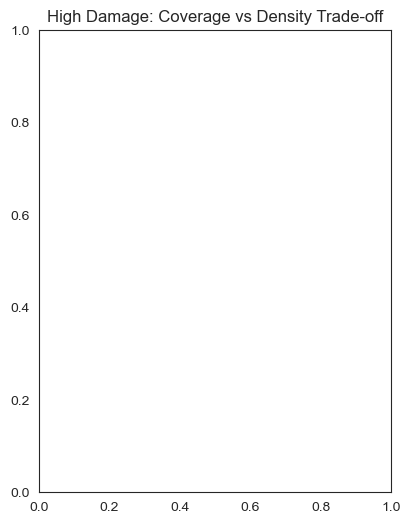

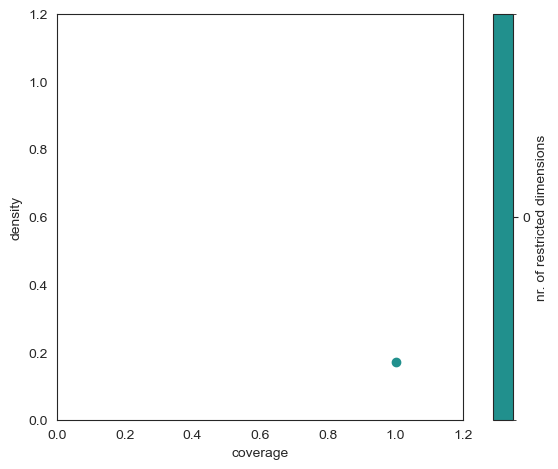

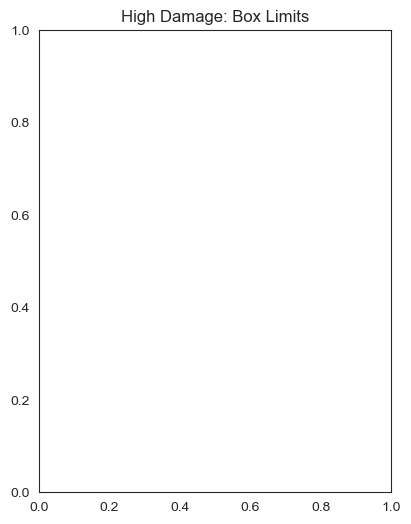

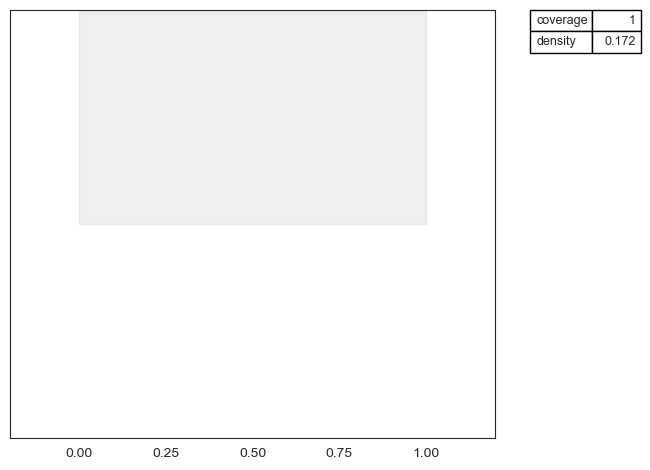

\nHigh Deaths PRIM Box:


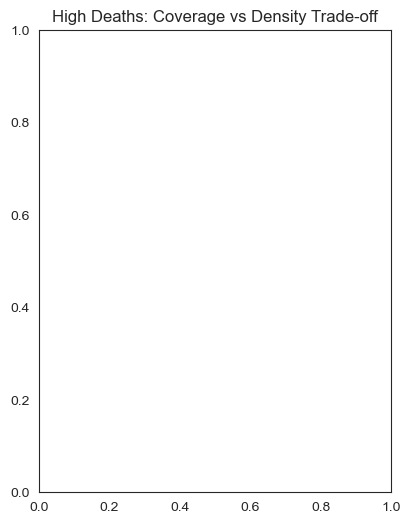

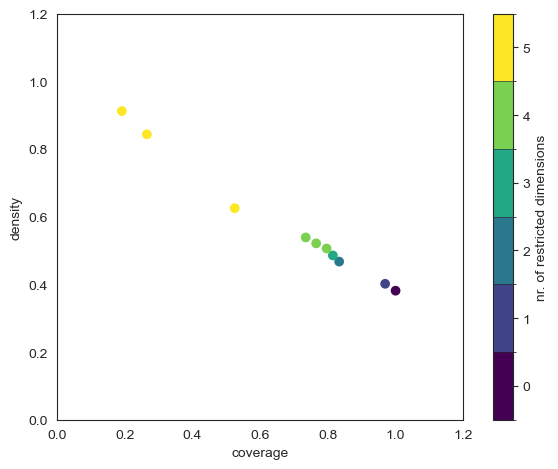

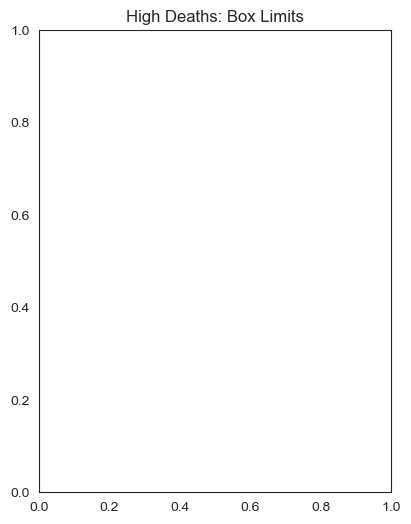

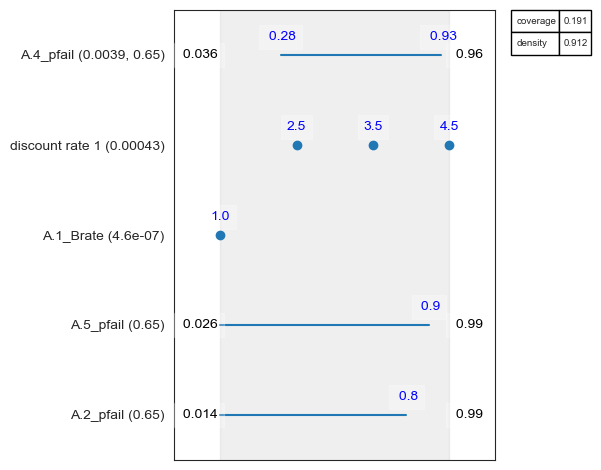

\nPRIM Box Analysis - High Damage Scenarios:
Coverage: 1.000
Density: 0.172
Box limits:
  Box limits available: 1 boxes
\nPRIM Box Analysis - High Deaths Scenarios:
Coverage: 0.191
Density: 0.912
Box limits:
  Box limits available: 10 boxes
\nSelected 425 vulnerable scenarios from PRIM box


In [ ]:
# Visualize PRIM results
print("Creating PRIM visualizations...")

# High damage PRIM results
print("\\nHigh Damage PRIM Box:")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('High Damage: Coverage vs Density Trade-off')
try:
    box_damage.show_tradeoff()  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create tradeoff plot: {e}")
    plt.close()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)  
plt.title('High Damage: Box Limits')
try:
    box_damage.inspect(style='graph')  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create inspection plot: {e}")
    plt.close()

# High deaths PRIM results
print("\\nHigh Deaths PRIM Box:")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('High Deaths: Coverage vs Density Trade-off')
try:
    box_deaths.show_tradeoff()  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create tradeoff plot: {e}")
    plt.close()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)
plt.title('High Deaths: Box Limits') 
try:
    box_deaths.inspect(style='graph')  # No ax parameter
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create inspection plot: {e}")
    plt.close()

# Print PRIM box details
print("\\nPRIM Box Analysis - High Damage Scenarios:")
try:
    print(f"Coverage: {box_damage.coverage:.3f}")
    print(f"Density: {box_damage.density:.3f}")
    
    # Try different ways to access box limits
    print("Box limits:")
    try:
        # Method 1: Try .limits attribute
        for var, (lower, upper) in box_damage.limits.items():
            print(f"  {var}: [{lower:.3f}, {upper:.3f}]")
    except AttributeError:
        try:
            # Method 2: Try .box_lims attribute
            if hasattr(box_damage, 'box_lims'):
                print(f"  Box limits available: {len(box_damage.box_lims)} boxes")
            else:
                print("  Box limits format not accessible in this version")
        except:
            print("  Could not access box limit details")
            
except Exception as e:
    print(f"Could not access high damage PRIM box details: {e}")

print("\\nPRIM Box Analysis - High Deaths Scenarios:")
try:
    print(f"Coverage: {box_deaths.coverage:.3f}")
    print(f"Density: {box_deaths.density:.3f}")
    
    # Try different ways to access box limits
    print("Box limits:")
    try:
        # Method 1: Try .limits attribute
        for var, (lower, upper) in box_deaths.limits.items():
            print(f"  {var}: [{lower:.3f}, {upper:.3f}]")
    except AttributeError:
        try:
            # Method 2: Try .box_lims attribute
            if hasattr(box_deaths, 'box_lims'):
                print(f"  Box limits available: {len(box_deaths.box_lims)} boxes")
            else:
                print("  Box limits format not accessible in this version")
        except:
            print("  Could not access box limit details")
            
except Exception as e:
    print(f"Could not access high deaths PRIM box details: {e}")

# Select representative scenarios for Multi-Scenario MORDM
# Extract scenarios within the high damage box
try:
    vulnerable_scenario_indices = box_damage.yi
    vulnerable_scenarios = experiments_for_prim.iloc[vulnerable_scenario_indices]
    print(f"\\nSelected {len(vulnerable_scenarios)} vulnerable scenarios from PRIM box")
except Exception as e:
    print(f"\\nCould not extract scenarios from PRIM box: {e}")
    print("Using alternative approach: selecting scenarios with highest damage")
    
    # Fallback: Use scenarios with highest damage as vulnerable scenarios
    damage_values = outcomes_robust.get('Expected Annual Damage', outcomes_robust[list(outcomes_robust.keys())[0]])
    top_damage_indices = np.argsort(damage_values)[-min(10, len(damage_values)):]  # Top 10 or all available
    vulnerable_scenarios = experiments_for_prim.iloc[top_damage_indices]
    print(f"Selected {len(vulnerable_scenarios)} high-damage scenarios as fallback")


## Phase 5: Multi-Scenario MORDM Setup

This phase extends the analysis to Multi-Scenario MORDM by selecting representative scenarios and preparing for optimization across multiple futures.


In [ ]:
# Multi-Scenario MORDM: Select representative scenarios
import sys
import os
sys.path.append(os.path.join('..', 'Week 5-6 - robustness and direct search'))
from assignment_10_scenario_selection import find_maxdiverse_scenarios, evaluate_diversity_single
import itertools
from scipy.spatial.distance import pdist, squareform

# Select 4-5 diverse scenarios from vulnerable scenarios
n_selected_scenarios = 4

if len(vulnerable_scenarios) > n_selected_scenarios:
    # Calculate distances between scenarios
    scenario_matrix = vulnerable_scenarios.values
    distances = squareform(pdist(scenario_matrix, metric='euclidean'))
    
    # Check if combination space is manageable
    from math import comb
    n_scenarios = len(vulnerable_scenarios)
    total_combinations = comb(n_scenarios, n_selected_scenarios)
    
    print(f"Total possible combinations: {total_combinations}")
    
    if total_combinations > 10000:  # Limit to prevent memory issues
        print("Too many combinations for exhaustive search. Using random sampling approach...")
        
        # Random sampling approach for large combination spaces
        np.random.seed(42)  # For reproducibility
        best_diversity = -1
        best_combination = None
        
        # Sample 1000 random combinations instead of all combinations
        n_samples = min(1000, total_combinations)
        for _ in range(n_samples):
            random_indices = np.random.choice(n_scenarios, n_selected_scenarios, replace=False)
            diversity = evaluate_diversity_single(random_indices, distances)
            if diversity[0] > best_diversity:
                best_diversity = diversity[0]
                best_combination = random_indices
        
        selected_scenarios = vulnerable_scenarios.iloc[best_combination]
        print(f"Selected scenarios using random sampling (diversity: {best_diversity:.3f})")
        
    else:
        print("Using exhaustive search for scenario combinations...")
        # Original exhaustive approach for smaller combination spaces
        scenario_combinations = list(itertools.combinations(range(len(vulnerable_scenarios)), n_selected_scenarios))
        scores = find_maxdiverse_scenarios(distances, scenario_combinations)
        
        # Select best combination (highest diversity)
        best_combination = max(scores, key=lambda x: x[0])[1]
        selected_scenarios = vulnerable_scenarios.iloc[list(best_combination)]
        print(f"Selected scenarios using exhaustive search (diversity: {max(scores, key=lambda x: x[0])[0][0]:.3f})")

else:
    # Use all available scenarios if we have fewer than desired
    selected_scenarios = vulnerable_scenarios
    best_combination = list(range(len(vulnerable_scenarios)))
    print(f"Using all {len(vulnerable_scenarios)} available scenarios (fewer than requested {n_selected_scenarios})")

print(f"Multi-Scenario MORDM Setup:")
print(f"- Selected {len(selected_scenarios)} scenarios from {len(vulnerable_scenarios)} vulnerable scenarios")
print(f"- Scenario selection method: Diversity maximization")

# Convert selected scenarios to Scenario objects for optimization
selected_scenario_objects = []
for i, (idx, scenario_row) in enumerate(selected_scenarios.iterrows()):
    scenario_dict = scenario_row.to_dict()
    scenario_name = f"Vulnerable_Scenario_{i+1}"
    selected_scenario_objects.append(Scenario(scenario_name, **scenario_dict))

print(f"- Created {len(selected_scenario_objects)} Scenario objects")

# Display scenario characteristics
print("\\nSelected Scenario Characteristics:")
print(selected_scenarios.describe())


Total possible combinations: 1340282550
Too many combinations for exhaustive search. Using random sampling approach...
Selected scenarios using random sampling (diversity: 375.912)
Multi-Scenario MORDM Setup:
- Selected 4 scenarios from 425 vulnerable scenarios
- Scenario selection method: Diversity maximization
- Created 4 Scenario objects
\nSelected Scenario Characteristics:
       A.0_ID flood wave shape    A.1_Bmax  A.1_pfail    A.2_Bmax  A.2_pfail  \
count                 4.000000    4.000000   4.000000    4.000000   4.000000   
mean                 62.500000  239.497311   0.434212  220.785826   0.404168   
std                  42.304452  121.060648   0.207704  110.674145   0.267922   
min                  13.000000   63.666828   0.182258   84.632067   0.099344   
25%                  40.750000  214.642223   0.342212  154.985125   0.245178   
50%                  61.500000  278.107979   0.434839  236.464956   0.397950   
75%                  83.250000  302.963066   0.526839  302.2

## Phase 6: Global Sensitivity Analysis (SOBOL)

We perform SOBOL sensitivity analysis to identify which uncertainties most significantly influence the model outcomes.


In [5]:
# SOBOL Global Sensitivity Analysis
print(f"Performing SOBOL sensitivity analysis with {n_sobol_samples} samples...")

# Get SALib problem formulation
sa_problem = get_SALib_problem(dike_model.uncertainties)

# Generate SOBOL samples
sobol_samples = saltelli.sample(sa_problem, n_sobol_samples)
n_experiments = len(sobol_samples)

print(f"Generated {n_experiments} SOBOL samples for {len(dike_model.uncertainties)} uncertainties")

# Convert SOBOL samples to the format EMA Workbench expects
print("Converting SOBOL samples for EMA Workbench...")
uncertainty_names = [unc.name for unc in dike_model.uncertainties]

# Create experiments DataFrame with SOBOL samples
experiments_df = pd.DataFrame(sobol_samples, columns=uncertainty_names)

# Add default policy lever values (reference policy)
print("Adding default policy lever values...")
lever_names = [lever.name for lever in dike_model.levers]

# Set all policy levers to default/reference values
for lever_name in lever_names:
    if 'DikeIncrease' in lever_name:
        experiments_df[lever_name] = 0  # No dike increase
    elif 'RfR' in lever_name:
        experiments_df[lever_name] = 0  # No Room for River
    elif 'EWS_DaysToThreat' in lever_name:
        experiments_df[lever_name] = 0  # No early warning

print(f"Added {len(lever_names)} policy levers with default values")

# Convert experiments to proper Scenario objects
print("Converting experiments to Scenario objects...")
scenario_objects = []
for idx, row in experiments_df.iterrows():
    scenario_name = f"SOBOL_Scenario_{idx:04d}"
    scenario_dict = row.to_dict()
    scenario_objects.append(Scenario(scenario_name, **scenario_dict))

print(f"Created {len(scenario_objects)} Scenario objects")

# Use the EMA Workbench evaluator with proper Scenario objects
print("Running model evaluations for SOBOL analysis...")
with MultiprocessingEvaluator(dike_model) as evaluator:
    print(f"Starting {len(scenario_objects)} model evaluations...")
    sobol_results = evaluator.perform_experiments(
        scenarios=scenario_objects
    )

sobol_experiments, sobol_outcomes = sobol_results

print("SOBOL experiments completed")

# Perform SOBOL analysis for each outcome
sobol_indices = {}
outcome_names = [outcome.name for outcome in dike_model.outcomes]

for outcome_name in outcome_names:
    print(f"Analyzing sensitivity for {outcome_name}...")
    
    # Get model outputs for this outcome
    if isinstance(sobol_outcomes[outcome_name], list):
        Y = np.array(sobol_outcomes[outcome_name])
    else:
        Y = sobol_outcomes[outcome_name].values
    
    # Remove NaN values for SOBOL analysis
    Y_clean = Y[~np.isnan(Y)]
    if len(Y_clean) < len(Y):
        print(f"Warning: Removed {len(Y) - len(Y_clean)} NaN values from {outcome_name}")
    
    # Compute SOBOL indices
    Si = sobol.analyze(sa_problem, Y_clean)
    sobol_indices[outcome_name] = Si

print("SOBOL analysis completed")

# Visualize SOBOL indices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, outcome_name in enumerate(outcome_names[:6]):  # Show first 6 outcomes
    if i < len(axes):
        ax = axes[i]
        
        # Extract first-order indices
        S1 = sobol_indices[outcome_name]['S1']
        conf = sobol_indices[outcome_name]['S1_conf']
        
        # Create bar plot
        x_pos = np.arange(len(sa_problem['names']))
        bars = ax.bar(x_pos, S1, yerr=conf, capsize=3, alpha=0.7)
        
        ax.set_title(f'SOBOL Indices: {outcome_name}', fontsize=10)
        ax.set_xlabel('Uncertainties')
        ax.set_ylabel('First-order Sensitivity Index')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(sa_problem['names'], rotation=45, ha='right')
        ax.grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(outcome_names), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Print top sensitive uncertainties for each outcome
print("\\nTop 3 Most Influential Uncertainties by Outcome:")
for outcome_name in outcome_names:
    S1 = sobol_indices[outcome_name]['S1']
    uncertainty_names = sa_problem['names']
    
    # Get top 3 uncertainties
    top_indices = np.argsort(S1)[-3:][::-1]
    
    print(f"\\n{outcome_name}:")
    for j, idx in enumerate(top_indices):
        print(f"  {j+1}. {uncertainty_names[idx]}: S1 = {S1[idx]:.3f}")

print("\\nMORDM Analysis Complete!")


Performing SOBOL sensitivity analysis with 128 samples...
Generated 5120 SOBOL samples for 19 uncertainties
Converting SOBOL samples for EMA Workbench...
Adding default policy lever values...
Added 31 policy levers with default values
Converting experiments to Scenario objects...
Created 5120 Scenario objects
Running model evaluations for SOBOL analysis...


KeyboardInterrupt: 